In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
import pyro
from BNN_Dropout import NN_Dropout, BNN_Dropout
from BNN_SGDHMC import BNN_SGDHMC
from BNN_SVI import BNN_SVI
from BNN_BBB import BNN_BBB


from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


 /home/alaya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


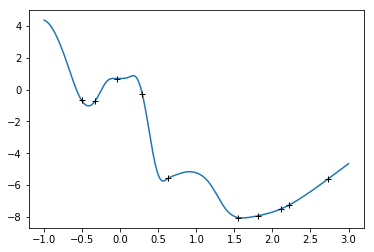

In [5]:
bench = RandomNN(1,2,50,nn.Tanh())
bench.rand_normal_weight(1)
num_plot  = 1000
num_train = 10
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x).detach()
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [10]:
conf = dict()
conf['num_epochs'] = 1600
conf['num_hidden'] = 50
conf['num_layers'] = 3
conf['batch_size'] = 128


conf['dropout_rate'] = 0.01
conf['lr']           = 0.01
conf['tau']          = 1.5 #0.15
conf['lscale']       = 0.25


model = BNN_Dropout(1,nn.Tanh(), conf)

conf_hmc = dict()
hmc_model = BNN_SGDHMC(dim = 1, act = nn.Tanh(), conf = conf_hmc)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

conf_svi = dict()
conf_svi['num_iters'] = 4000
conf_svi['lr'] = 1e-2
conf_svi['num_layers'] = 1
conf_svi['noise_level'] = 0.05
svi_model = BNN_SVI(dim = 1, act = nn.Tanh(), conf = conf_svi)

conf_bbb                = dict()
conf_bbb['num_epochs']  = 4000
conf_bbb['batch_size']  = 25
conf_bbb['num_layers']  = 1
conf_bbb['print_every'] = 50
conf_bbb['lr']          = 3e-2
conf_bbb['noise_level'] = 0.05
bbb_model                   = BNN_BBB(dim = 1, act = nn.Tanh(), conf = conf_bbb)

In [11]:
bbb_model.train(train_x,train_y)
svi_model.train(train_x, train_y)
hmc_model.train(train_x, train_y)
model.train(train_x, train_y)
gp.optimize()

[Epoch    50, loss = 1.738e+05 (KL = 136.3, -log_lik = 1.737e+05)]
[Epoch   100, loss = 1.376e+04 (KL = 163.5, -log_lik = 1.36e+04)]
[Epoch   150, loss = 1.551e+04 (KL = 140.2, -log_lik = 1.537e+04)]
[Epoch   200, loss = 2.097e+04 (KL = 150, -log_lik = 2.082e+04)]
[Epoch   250, loss = 3998 (KL = 158.7, -log_lik = 3840)]
[Epoch   300, loss = 2365 (KL = 154.2, -log_lik = 2211)]
[Epoch   350, loss = 2510 (KL = 160, -log_lik = 2350)]
[Epoch   400, loss = 5523 (KL = 159.9, -log_lik = 5363)]
[Epoch   450, loss = 2.468e+04 (KL = 180.6, -log_lik = 2.45e+04)]
[Epoch   500, loss = 8669 (KL = 180, -log_lik = 8489)]
[Epoch   550, loss = 2286 (KL = 171.5, -log_lik = 2114)]
[Epoch   600, loss = 1.356e+04 (KL = 166.6, -log_lik = 1.34e+04)]
[Epoch   650, loss = 1483 (KL = 177.6, -log_lik = 1305)]
[Epoch   700, loss = 7726 (KL = 179.3, -log_lik = 7547)]
[Epoch   750, loss = 1541 (KL = 168.6, -log_lik = 1372)]
[Epoch   800, loss = 6040 (KL = 193.3, -log_lik = 5847)]
[Epoch   850, loss = 813.1 (KL = 202.

Step      100 : NLL =  1.0125e+03 MSE = 2.3236e+01 Time =  0.66
Step      200 : NLL =  1.3010e+03 MSE = 2.3893e+01 Time =  1.20
Step      300 : NLL =  1.5609e+03 MSE = 2.3175e+01 Time =  1.76
Step      400 : NLL =  1.9901e+03 MSE = 2.3599e+01 Time =  2.29
Step      500 : NLL =  2.4210e+03 MSE = 2.3479e+01 Time =  2.86
Step      600 : NLL =  2.9549e+03 MSE = 2.3610e+01 Time =  3.44
Step      700 : NLL =  3.5616e+03 MSE = 2.3706e+01 Time =  4.03
Step      800 : NLL =  4.2120e+03 MSE = 2.3322e+01 Time =  4.63
Step      900 : NLL =  5.0845e+03 MSE = 2.2901e+01 Time =  5.25
Step     1000 : NLL =  6.2649e+03 MSE = 2.3006e+01 Time =  5.71
Step     1100 : NLL =  7.2997e+03 MSE = 2.2378e+01 Time =  6.11
Step     1200 : NLL =  9.1606e+03 MSE = 2.3458e+01 Time =  6.52
Step     1300 : NLL =  1.1167e+04 MSE = 2.3442e+01 Time =  6.93
Step     1400 : NLL =  1.3366e+04 MSE = 2.3392e+01 Time =  7.49
Step     1500 : NLL =  1.6659e+04 MSE = 2.3733e+01 Time =  8.12
Step     1600 : NLL =  1.9100e+04 MSE = 

 /mnt/c/code/pybnn/pybnn/bohamiann.py:119: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step     2100 : NLL =  4.8667e+04 MSE = 2.3410e+01 Samples= 1 Time = 11.89
Step     2200 : NLL =  2.2952e+04 MSE = 2.3322e+01 Samples= 3 Time = 12.32
Step     2300 : NLL =  8.1588e+03 MSE = 2.3542e+01 Samples= 5 Time = 12.90
Step     2400 : NLL =  6.6780e+03 MSE = 2.3669e+01 Samples= 7 Time = 13.73
Step     2500 : NLL =  7.0907e+03 MSE = 2.3641e+01 Samples= 9 Time = 14.45
Step     2600 : NLL =  6.2349e+03 MSE = 2.3602e+01 Samples= 11 Time = 15.20
Step     2700 : NLL =  5.9966e+03 MSE = 2.3571e+01 Samples= 13 Time = 15.65
Step     2800 : NLL =  6.5166e+03 MSE = 2.3552e+01 Samples= 15 Time = 16.11
Step     2900 : NLL =  6.1667e+03 MSE = 2.3546e+01 Samples= 17 Time = 16.56
Step     3000 : NLL =  6.0837e+03 MSE = 2.3538e+01 Samples= 19 Time = 16.98
Step     3100 : NLL =  6.4828e+03 MSE = 2.3527e+01 Samples= 21 Time = 17.45
Step     3200 : NLL =  6.7690e+03 MSE = 2.3514e+01 Samples= 23 Time = 17.88
Step     3300 : NLL =  5.2203e+03 MSE = 2.3501e+01 Samples= 25 Time = 18.27
Step     3400 : N

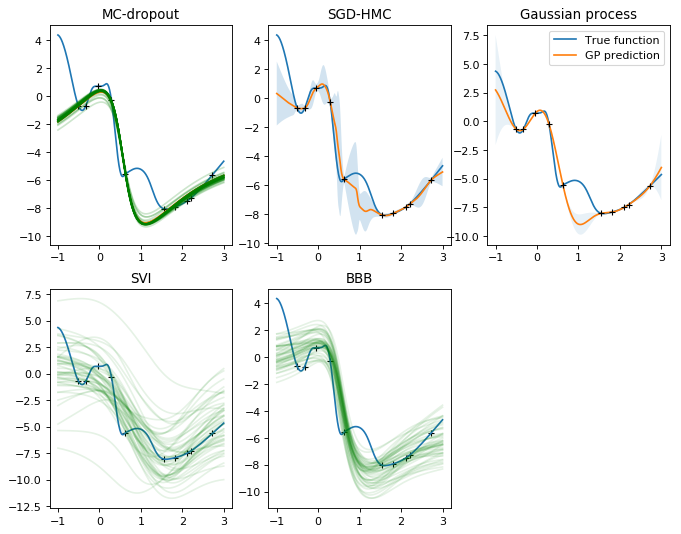

In [12]:
#py = model.predict(x)
py,pv = model.predict_mv(x)
ps = torch.sqrt(pv)
m_hmc,v_hmc = hmc_model.predict_mv(x)
m_hmc = m_hmc.detach().numpy().reshape(num_plot)
s_hmc   = v_hmc.sqrt().detach().numpy().reshape(num_plot)
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(231)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
plt.fill_between(
    x.numpy().reshape(num_plot), 
    (py - ps).reshape(num_plot).detach().numpy(), 
    (py + ps).reshape(num_plot).detach().numpy(), alpha = 0.0)
for i in range(50):
    net = model.sample()
    py  = net((x - model.x_mean) / model.x_std) * model.y_std + model.y_mean
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.2)
plt.title('MC-dropout')

plt.subplot(232)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(x.numpy(), m_hmc)
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), m_hmc +3* s_hmc, m_hmc -3* s_hmc, alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(233)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - 3 * np.sqrt(gp_v)).reshape(num_plot), (gp_m + 3 * np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')


plt.subplot(234)
plt.title('SVI')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')

num_samples = 50;
for i in range(50):
    r_net = svi_model.sample()
    py     = svi_model.sample_predict(r_net,x)
    plt.plot(x.numpy(), py.detach().numpy(),'g',alpha = 0.1)
    
plt.subplot(235)
plt.title('BBB')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')

num_samples = 50;
for i in range(50):
    py   = bbb_model.nn((x - bbb_model.x_mean) / bbb_model.x_std) 
    py   = py * bbb_model.y_std + bbb_model.y_mean
    plt.plot(x.numpy(), py.detach().numpy(),'g',alpha = 0.1)

In [13]:
xs = torch.linspace(-10,10,1000)
f = nn.Softplus()

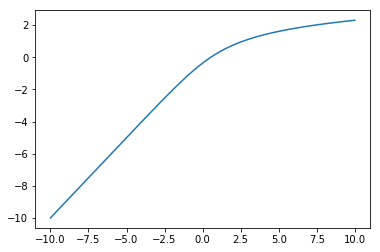

In [18]:
plt.plot(xs.numpy(), f(xs).log().detach().numpy())

In [16]:
f(xs).min()

tensor(4.5399e-05)